In [3]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import time
import sys
import os
from function import *
from my_NN import *
import ycx_para_config as ycx
import matplotlib.pyplot as plt

debug=False
debug_2=False

boundary_loss_list=[]
consist_loss_list=[]

# Get the current directory of the notebook
notebook_dir = os.getcwd()

# Get the absolute path to the 'network' directory
network_path = os.path.join(notebook_dir, '../network')

# Add the 'network' directory to sys.path
sys.path.append(os.path.abspath(network_path))


def equally_random_points_in_interval(n, num_samples=1):
    # Define the equal division points (excluding 0 and 1)
    nodes = np.linspace(1/n, 1-1/n, n-1)

    # Define the segment length, which is 1/n
    segment_length = 1/n

    # Define sigma as segment_length / 3
    sigma = segment_length / 5

    # Sample randomly around each node using normal distribution
    #sampled_points = np.array([np.random.normal(loc=node, scale=sigma, size=num_samples) for node in nodes])
    sampled_points = np.array([np.random.rand()*2*ycx.random_amplititude/n+node-ycx.random_amplititude/n for node in nodes])
    
    sampled_points = np.insert(sampled_points, 0, 0.)
    sampled_points = np.append(sampled_points, 1.)
    sampled_points = np.sort(sampled_points)
    return sampled_points


def generate_consist_tuples(points, tuple_len, max_p):
    # given a list of points, create all tuples used for consist condition in tuple_len and each tuple has no more than max_p points
    results = []
    for r in range(3, max_p + 1):
        result = []
        for i in range(len(points) - tuple_len+1):#这里可能range（）里面需要加1
            this_points = points[i: i+tuple_len]
            result = list(set(result + list(itertools.combinations(this_points, r))))
        results.append(result)
    return results


def calc_consist_loss(model, tuples,
                      dtype=torch.float32, device='cpu'):
    point_tuples = torch.tensor(tuples, device=device, dtype=dtype)
    point_tuples = point_tuples.unsqueeze(-1)
    f0s = 0.1 + 0.8 * torch.rand((point_tuples.shape[0], 1), dtype=dtype, device=device)
    # one step
    deltas = point_tuples[:, -1] - point_tuples[:, 0]
    result = f0s + deltas * model(f0s, point_tuples[:, 0], deltas)

    # multiple steps
    step = point_tuples.shape[1]-1
    fs = f0s.clone()
    deltas = torch.zeros((step, point_tuples.shape[0], 1), dtype=dtype, device=device)
    for i in range(step):
        deltas[i] = point_tuples[:, i+1] - point_tuples[:, i]
    for i in range(step):
        fs = fs + deltas[i] * model(fs, point_tuples[:, i], deltas[i])
    loss_fn = nn.MSELoss()
    norm_factors = torch.sum(deltas, dim=0)**2
    loss = loss_fn(result/norm_factors, fs/norm_factors)
    #---------
    if(debug==True):print('consist_loss: ',loss.item())
    #---------
    return loss


def calc_boundary_loss(model, x_segments, repeated_time, tuple_len, boundary_fn,dtype=torch.float32, device='cpu'):
    f0s = 0.1 + 0.8 * torch.rand((repeated_time, 1), dtype=dtype, device=device)
    ####从0.9改回0.4
    f1s = boundary_fn(f0s)
    points = x_segments[::tuple_len]
    points = torch.from_numpy(points)
    points = points.to(dtype=dtype, device=device)
    
    points = points.unsqueeze(-1).repeat(1, repeated_time)
    points = points.unsqueeze(-1)
    deltas = points[1:] - points[:-1]
    step = len(points)-1
    if debug:print('points_of_boundary_loss_calc:',points.squeeze(-1),points.shape)

    fs = f0s
    for i in range(step):
        fs = fs + deltas[i] * model(fs, points[i], deltas[i])
    loss_fn = nn.MSELoss()
    loss = loss_fn(fs, f1s)
    if debug_2:
        debug_loss_fun=nn.MSELoss(reduction='none')
        debug_loss=debug_loss_fun(fs, f1s)
        print('boundary_loss:', debug_loss)

    return loss


def iteration(model, p, optimizer, boundary_fn,
              tuple_len=8, max_p=6,
              dtype=torch.float32, device='cpu'):
    #迭代更新函数
    optimizer.zero_grad()

    segments_per_interval = 2**(p)   # 每一个间隔所分割的段数

    x_segments = equally_random_points_in_interval(segments_per_interval, num_samples=1)

    tuples = generate_consist_tuples(x_segments, tuple_len, max_p)

    consist_loss = 0.0

    for t in tuples:
        temp_consist_loss = calc_consist_loss(model, t, dtype=dtype, device=device)
        if debug_2:
            print('temp_consist_loss:',temp_consist_loss.item())
            print('len of t:',len(t),'  mean loss of t:',temp_consist_loss.item()/len(t))
        consist_loss = consist_loss + temp_consist_loss

    repeated_time = sum(len(t) for t in tuples)
    # #--------------
    # if(debug==True):
    #     for t in tuples:print('\n len(t):',len(t),'\n')
    # #--------------
    boundary_loss = calc_boundary_loss(model, x_segments, repeated_time, tuple_len, boundary_fn, dtype=dtype, device=device)
    if debug_2:print('boundary_loss:',boundary_loss.item())
    
    boundary_loss_list.append(boundary_loss.item())
    consist_loss_list.append(consist_loss.item())
    loss = consist_loss  + boundary_loss
    # #-----------
    # if(debug==True):print('sum_loss:',loss.item())
    # #-----------
    loss.backward()
    optimizer.step()

    return loss.item()


def train(model, p=7, tuple_len=8, max_p=6,
          boundary_fn=ycx.choose_fun,
          lr=0.01, num_batches=64, max_epoch=10000,
          device='cpu', dtype=torch.float32,
          use_scheduler=True, patience=20, threshold=1e-4, cooldown=2):
    ####为什么这里的divice='cpu'，而不是device='cuda'呢？
    list_epoch_loss_mean=[]
    
    
    model.train()
    #激活训练状态，model.train() 将模型切换到训练模式，以便在训练中启用 Dropout 和 BatchNorm 等特定行为。
    #Dropout：在评估过程中，Dropout 层会禁用，即所有神经元都参与计算。
    #BatchNorm：在评估过程中，BatchNorm 层会使用在训练过程中计算并存储的全局统计数据，而不是当前批次的数据。
    
    model = model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr,
                                 **({"fused": True} if "cuda" in str(device) else {}))#这里的fused=True，是为了使用apex加速

    # Use ReduceLROnPlateau as the learning rate scheduler
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               patience=ycx.lr_schedule_patience,
                                                               threshold=threshold,
                                                               cooldown=ycx.lr_schedule_cooldown)

    for epoch in range(max_epoch):
        lst_loss_epoch = []

        for z in range(num_batches):
            loss_epoch = iteration(model, p, optimizer=optimizer, boundary_fn=boundary_fn,
                                   tuple_len=tuple_len, max_p=max_p, dtype=dtype, device=device)
            lst_loss_epoch.append(loss_epoch)

        loss_epoch_mean = np.array(lst_loss_epoch).mean()
        ####
        if(epoch%20==0):
            list_epoch_loss_mean.append(loss_epoch_mean)
            torch.save(model.state_dict(), f"test_{p}_{tuple_len}_{max_p}.pth")

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss_epoch_mean}, LR = {optimizer.param_groups[0]['lr']}", flush=True)

        if use_scheduler:
            scheduler.step(loss_epoch_mean)

        if optimizer.param_groups[0]["lr"] <= 1.1e-8:
            print('terminal epoch: ',epoch)
            break
    ####
    print('list_of_loss_mean_epoch: ',list_epoch_loss_mean)
    # Save model ecm to disk
    torch.save(model.state_dict(), f"test_{p}_{tuple_len}_{max_p}.pth")


if __name__ == "__main__":
    ti = time.time()
    model = ycx.NN()
    device = 'cuda'
    dtype = torch.float32
    
    from torch.nn import init
    for name, param in model.named_parameters():
        if 'weight' in name:
            init.normal_(param, mean=0, std=0.1)
        elif 'bias' in name:
            init.constant_(param, val=0)
            
    train(model, boundary_fn=ycx.choose_fun,max_epoch=ycx.epoch,lr=ycx.lr,tuple_len=8,max_p=6,num_batches=ycx.iteration_num,device=device,dtype=dtype)#修改max_epoch=5
    print('---------------------------------')
    print('\n\nRun time showed here :   ',time.time()-ti)

Epoch 5: Loss = 0.006824912270531058, LR = 0.01
Epoch 10: Loss = 0.0010035329542006366, LR = 0.01
Epoch 15: Loss = 0.000503842813486699, LR = 0.01
Epoch 20: Loss = 0.0003889272084052209, LR = 0.01
Epoch 25: Loss = 0.00031811183362151496, LR = 0.01
Epoch 30: Loss = 0.00026873248134506866, LR = 0.01
Epoch 35: Loss = 0.00022834799165138975, LR = 0.01
Epoch 40: Loss = 0.00019791071463259868, LR = 0.01
Epoch 45: Loss = 0.00017969494365388528, LR = 0.01
Epoch 50: Loss = 0.00015908253772067837, LR = 0.01
Epoch 55: Loss = 0.0001451222888135817, LR = 0.01
Epoch 60: Loss = 0.00013085765203868505, LR = 0.01
Epoch 65: Loss = 0.00011825650199170923, LR = 0.01
Epoch 70: Loss = 0.00013861243132851087, LR = 0.01
Epoch 75: Loss = 9.702369061415084e-05, LR = 0.01
Epoch 80: Loss = 0.00015593564148730366, LR = 0.01
Epoch 85: Loss = 0.0001114422320824815, LR = 0.01
Epoch 90: Loss = 0.00011103393262601458, LR = 0.01
Epoch 95: Loss = 0.00015209556477202568, LR = 0.01
Epoch 100: Loss = 0.00020046263398398878,

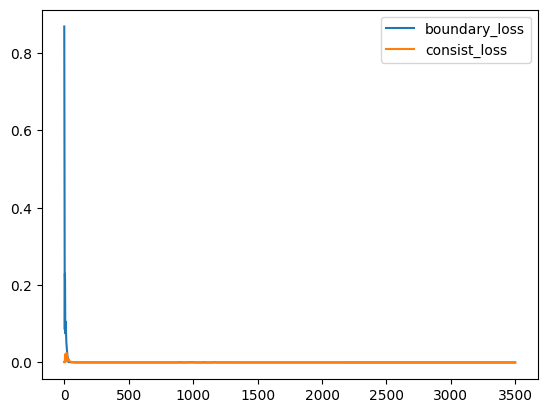

In [4]:
boundary_loss_list=np.array(boundary_loss_list)
consist_loss_list=np.array(consist_loss_list)

end=min(3500,len(boundary_loss_list))
begin=0

plt.plot(boundary_loss_list[begin:end],label='boundary_loss')
plt.plot(consist_loss_list[begin:end],label='consist_loss')
#plt.ylim(0,0.001)
plt.legend()
plt.show()